In [1]:
from astropy.table import Table, hstack, vstack, unique
from astropy import units as u
import astropy.coordinates as coord
from collections import Counter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pickle
import matplotlib
from pm_func_edr3 import *

In [2]:
num = "1"
model = Table.read("Data/allstar_Model"+num+"_Gas.fits")

print("Number of Model " + num + " stars is " + str(len(model)))

plotc = "magenta"  #tomato, royalblue, violet
#relc = "darkred"
#rvc = "forestgreen"

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

Number of Model 1 stars is 278864


In [3]:
#### Because this is sim data, it hasn't gone through other cuts, so I need to calculate x/y values

ra0 = np.deg2rad(13.038)
dec0 = np.deg2rad(-73.094)

center = np.asarray([ra0, dec0])

tempx, tempy = wcs2gaiaxy(np.deg2rad(model['RA']), np.deg2rad(model['DEC']), center)

## Add the cartesian coordinates as new columns to the catalog

tempx.shape = (len(tempx),)
tempy.shape = (len(tempy),)

model.add_column(tempx, name="x")
model.add_column(tempy, name="y")

In [4]:
####
# Calculate the viewing perspective correction for each source, using the above center
####

## Systemic information to be used, values used are intended for the RG population

incl = 0.000001
thet = 0.000001
muW = -0.68         #Center of mass proper motion east in mas/yr
muN = -1.23         #CM proper motion north	in mas/yr
vsys = 148.0          #CM radial velocity in km/s
m_M = 18.91


dist0 = (10**((m_M/5.0)+1)) / 1000.0      #distance in kpc to the galaxy center

mutran = (muW**2 + muN**2)**(0.5)         #total CM proper motion

thtran = np.deg2rad(np.rad2deg(np.arctan2((-1.0*muW),muN)) + 90.0) #angle of motion for the CM PM

vtran = 4.7403885 * mutran * dist0        #total CM velocity

In [5]:
## Perform the calculation of the perspective correction and add as columns

viewcor = np.zeros((len(model),3))
w, n, crv = 0, 1, 2

viewcor[:,w], viewcor[:,n], viewcor[:,crv] = viewing_cor(vtran, thtran, vsys, dist0, ra0, dec0, \
                                                         np.deg2rad(model['RA']), np.deg2rad(model['DEC']))

model.add_column(viewcor[:,w], name="muwcor")
model.add_column(viewcor[:,n], name="muncor")
model.add_column(viewcor[:,crv], name="rvcor")

print("")
print("Completed viewing corrections.")

D:\pzivi\Research\Gurtina_Project\pm_func_edr3.py:90: RuntimeWarning: invalid value encountered in arccos
  phi = np.arccos( (-1.0*np.cos(dec) * np.sin(ra - ra0)) / (np.sin(rho)) )



Completed viewing corrections.


In [6]:
####
# Calculate the relative proper motions of the stars
####

relmu = np.zeros((len(model), 3))
relmu[:,0] = (model['PMRA']) - (-1.0*(muW + viewcor[:,w]))
relmu[:,n] = (model['PMDEC']) - (muN + viewcor[:,n])

relmu[:,crv] = (np.zeros((len(model)))) - (vsys + viewcor[:,crv])

model.add_column(relmu[:,0], name="rel_pmra")
model.add_column(relmu[:,n], name="rel_pmdec")
model.add_column(relmu[:,crv], name="rel_rv")

print("")
print("Calculated relative motions.")


Calculated relative motions.


In [7]:
## convert this to x/y coordinates

relv = np.zeros((len(model),2))

relv[:,0], relv[:,1] = vecwcs2gaiaxy(relmu[:,0], relmu[:,1], np.deg2rad(model['RA']), \
                                     np.deg2rad(model['DEC']), center)

model.add_column(relv[:,0], name="rel_pmx")
model.add_column(relv[:,1], name="rel_pmy")

print("")
print("Converted relative motions to Cartesian frame")

## calculate the angle of the relative vector

relposang = np.rad2deg(np.arctan2(relv[:,0], relv[:,1]))
relposang.shape = (len(model),)

model.add_column(relposang, name="rel_PA")

print("")
print("Calculated angle of the relative vector")


Converted relative motions to Cartesian frame

Calculated angle of the relative vector


In [8]:
####
   # Set plotting bounds for the position and proper motion plots
####

displayvals = []

xmin, xmax, ymin, ymax = -5.0, 5.0, -6.0, 5.0

displayvals.append(xmin)
displayvals.append(xmax)
displayvals.append(ymin)
displayvals.append(ymax)

pmramin, pmramax, pmdecmin, pmdecmax, rvmin, rvmax = -1.5, 3.0, -3.5, 1.5, 50.0, 250.0

displayvals.append(pmramin)
displayvals.append(pmramax)
displayvals.append(pmdecmin)
displayvals.append(pmdecmax)
displayvals.append(rvmin)
displayvals.append(rvmax)


## Set bin widths

xwidth, ywidth = 0.4, 0.4 #0.2, 0.2

displayvals.append(xwidth)
displayvals.append(ywidth)

In [9]:
#### Now let's bin the data in X/Y space

pmbins = vec_grid(model, xwidth, xmax, xmin, ywidth, ymax, ymin, 'x', 'y', 'rel_pmx', 'rel_pmy')
pmbinx, pmbiny, pmbinpmx, pmbinpmy = 0, 1, 2, 3


## then convert them into polar coordinates

pmbins_pol = np.zeros((len(pmbins),4))
pmbins_pol[:,0], pmbins_pol[:,1], pmbins_pol[:,2], pmbins_pol[:,3] = xy2rt(pmbins[:,pmbinx], pmbins[:,pmbiny], \
                                                                           pmbins[:,pmbinpmx], pmbins[:,pmbinpmy])

polr, polt, polpmr, polpmt = 0, 1, 2, 3

<Figure size 432x288 with 0 Axes>

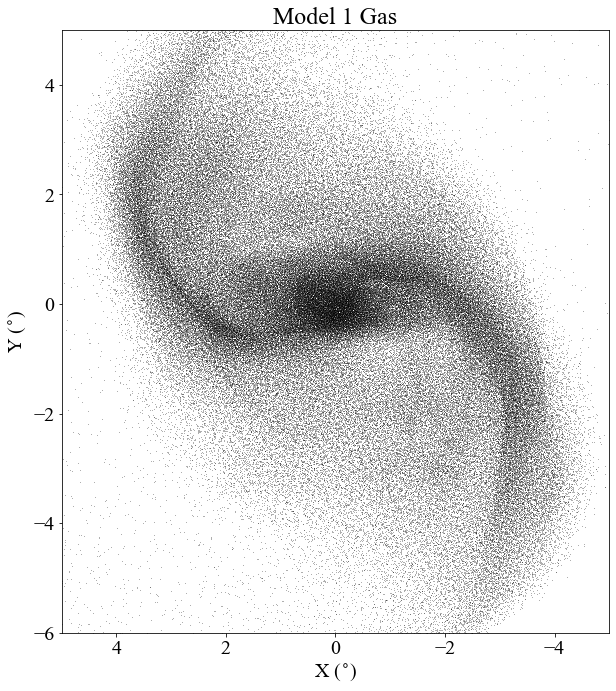

In [10]:
#### Display the data first

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['x'], model['y'], s=4, lw=0, marker=".", color="black", alpha=0.4)
#plt.scatter(rvgaia[:,xi], rvgaia[:,yi], s=4, lw=0, marker=".", color=rvc, alpha=0.5)

ax.set_xlabel(r'X ($^{\circ}$)')
ax.set_ylabel(r'Y ($^{\circ}$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Model " + num + " Gas")

ax.set_aspect("equal")
ax.invert_xaxis()
plt.tight_layout()
fig.savefig("Plots/Model" + num + "_Gas/XY_sky.png", dpi=300, facecolor="white", edgecolor='none')

<Figure size 432x288 with 0 Axes>

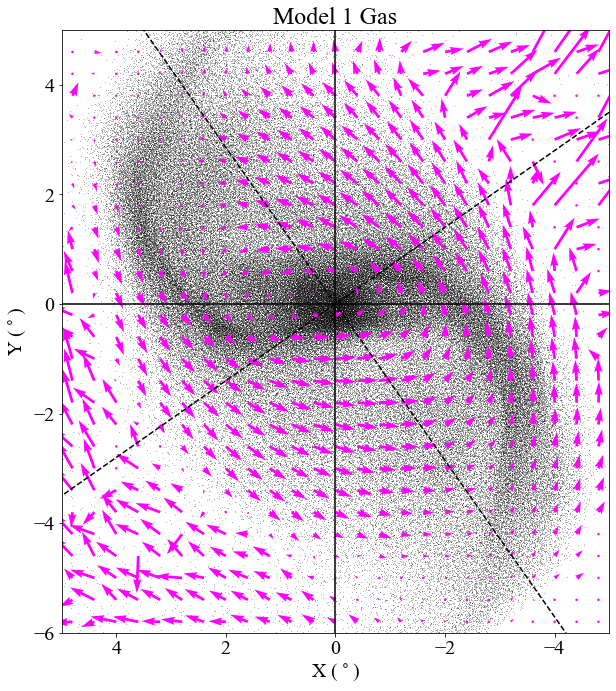

In [11]:
####
# Create the new axes for the new spatial/kinematic analysis
####

yaxis = np.asarray([[0.0, -8.0, 0.0], [0, 8.0, 0.0]])
xaxis = np.asarray([[-8.0, 0.0, 0.0], [8.0, 0.0, 0.0]])

tempcos = np.dot(yaxis[0], xaxis[0]) / (np.linalg.norm(yaxis[0])*np.linalg.norm(xaxis[0]))

#print np.rad2deg(np.arccos(tempcos))

axisrot = np.deg2rad(55.0)

newyaxis = rot3d(yaxis[:,0], yaxis[:,1], yaxis[:,2], rot_zaxis(axisrot))
newxaxis = rot3d(xaxis[:,0], xaxis[:,1], xaxis[:,2], rot_zaxis(axisrot))


tempcos2 = np.dot(newyaxis[0], newxaxis[0]) / (np.linalg.norm(newyaxis[0])*np.linalg.norm(newxaxis[0]))


#### 
# Plot averaged residual vectors
####

visscale = 5.0

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['x'], model['y'], s=2, lw=0, color="black", marker=".", alpha=0.4)
#version with no color
q1 = ax.quiver(pmbins[:,pmbinx], pmbins[:,pmbiny], \
                (-1.0*visscale*pmbins[:,pmbinpmx]), \
                (visscale*pmbins[:,pmbinpmy]), lw=2, \
                units="xy", scale=(visscale/2.0), color=plotc, \
                width=0.05)

# tidalxy = np.asarray([[0.0, 0.0]])
# tidalvxy = np.asarray([[0.43452, -0.20803]])

# q2 = ax.quiver(tidalxy[:,0], tidalxy[:,1], (-1.0*visscale*tidalvxy[:,0]), \
#                 (visscale*tidalvxy[:,1]), lw=0,  units="xy", \
#                 scale=(visscale/2.0), color=relc)


ax.plot(yaxis[:,0], yaxis[:,1], color="black")
ax.plot(xaxis[:,0], xaxis[:,1], color="black")

ax.plot(newyaxis[:,0], newyaxis[:,1], ls="--", color="black")
ax.plot(newxaxis[:,0], newxaxis[:,1], ls="--", color="black")

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title("Model " + num + " Gas")

ax.invert_xaxis()          
ax.set_aspect("equal")
plt.tight_layout()
fig.savefig("Plots/Model" + num + "_Gas/vec_respm.png", dpi=300, facecolor="white", edgecolor='none')

<Figure size 432x288 with 0 Axes>

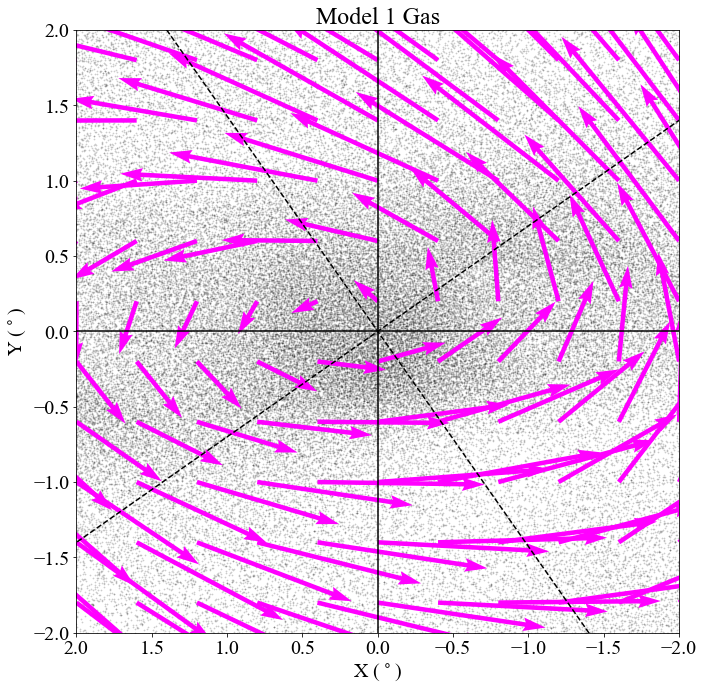

In [12]:
####
# Plot a zoomed in version on the center of the vector plot
####

visscale = 5.0

pmbins_zoom = pmbins[(abs(pmbins[:,pmbinx]) < 2.5) & \
                     (abs(pmbins[:,pmbiny]) < 2.5)]

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['x'], model['y'], s=3, lw=0, color="black", marker="o", alpha=0.2)
#version with no color
q1 = ax.quiver(pmbins_zoom[:,pmbinx], pmbins_zoom[:,pmbiny], \
                (-1.0*visscale*pmbins_zoom[:,pmbinpmx]), \
                (visscale*pmbins_zoom[:,pmbinpmy]), lw=0, \
                units="xy", scale=(visscale/6.0), color=plotc, width=0.03)

# q2 = ax.quiver(tidalxy[:,0], tidalxy[:,1], (-1.0*visscale*tidalvxy[:,0]), \
#                 (visscale*tidalvxy[:,1]), lw=0,  units="xy", \
#                 scale=(visscale/2.0), color=relc)


ax.plot(yaxis[:,0], yaxis[:,1], color="black")
ax.plot(xaxis[:,0], xaxis[:,1], color="black")

ax.plot(newyaxis[:,0], newyaxis[:,1], ls="--", color="black")
ax.plot(newxaxis[:,0], newxaxis[:,1], ls="--", color="black")

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)

ax.set_title("Model " + num + " Gas")

ax.invert_xaxis()          
ax.set_aspect("equal")
plt.tight_layout()
fig.savefig("Plots/Model" + num + "_Gas/vec_respm_zoom.png", dpi=300, facecolor="white", edgecolor='none')

<Figure size 432x288 with 0 Axes>

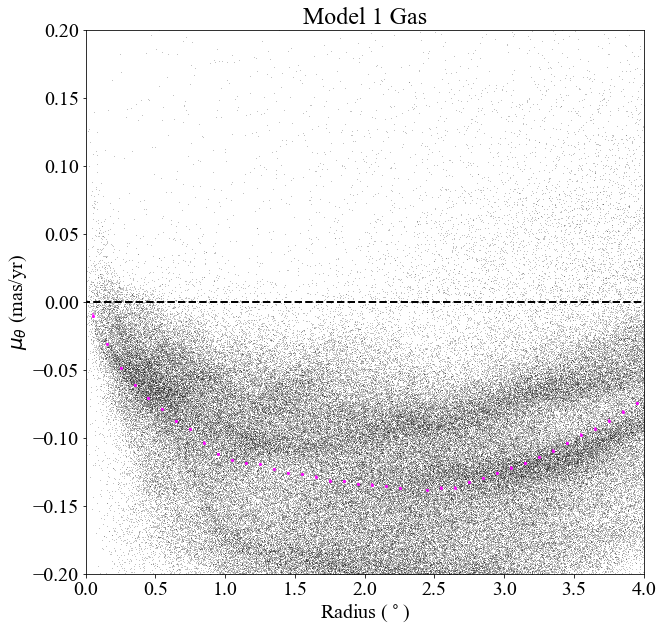

<Figure size 432x288 with 0 Axes>

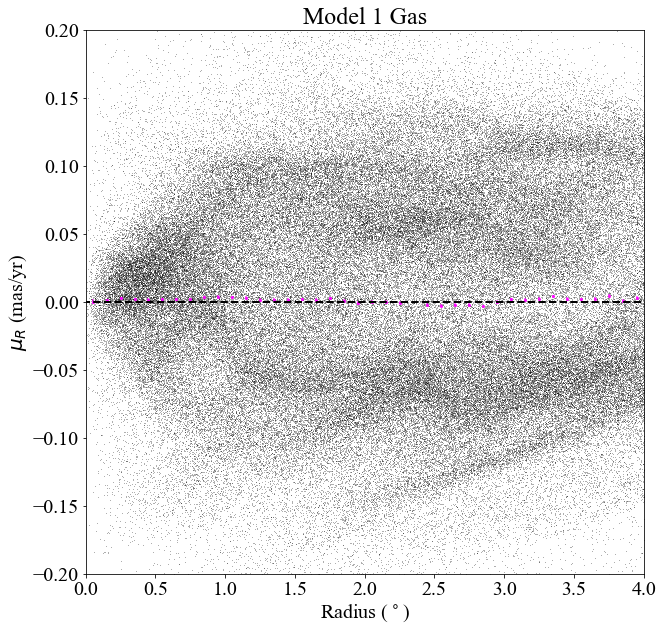

In [13]:
####
# Create 1D scatter plots for vt vs r and vr vs r, along with binned in radius

model_pol = np.zeros((len(model),4))
model_pol[:,0], model_pol[:,1], model_pol[:,2], model_pol[:,3] = xy2rt(model['x'], model['y'], \
                                                                   model['rel_pmx'], model['rel_pmy'])

polr, polt, polpmr, polpmt = 0, 1, 2, 3

#

polrpmt_bin = vec_1dgrid(model_pol, 0.1, 4.0, 0.0, polr, polpmt)
newr, pmavg, pmstd, pmnum = 0, 1, 2, 3


plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model_pol[:,polr], model_pol[:,polpmt], s=4, lw=0, marker=".", color="black", alpha=0.3)

ax.plot([-0.1, 4.1], [0.0, 0.0], lw=2, ls="--", color="black")

plt.scatter(polrpmt_bin[:,newr], polrpmt_bin[:,pmavg], s=10, lw=0, marker="o", color=plotc, alpha=0.9)

plt.errorbar(polrpmt_bin[:,newr], polrpmt_bin[:,pmavg], \
             yerr=(polrpmt_bin[:,pmstd]/np.sqrt(polrpmt_bin[:,pmnum])), \
             fmt='none',marker=None, mew=0, ecolor=plotc, alpha=0.7, zorder=1)

ax.set_xlim(0.0, 4.0)
ax.set_ylim(-0.2, 0.2)

ax.set_xlabel(r'Radius ($^\circ$)')
ax.set_ylabel(r'$\mu_{\theta}$ (mas/yr)')

ax.set_title("Model " + num + " Gas")

fig.savefig("Plots/Model" + num + "_Gas/r_vs_vt.png", dpi=300)
plt.show()

#

polrpmr_bin = vec_1dgrid(model_pol, 0.1, 4.0, 0.0, polr, polpmr)

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model_pol[:,polr], model_pol[:,polpmr], s=4, lw=0, marker=".", color="black", alpha=0.4)


ax.plot([-0.1, 4.1], [0.0, 0.0], lw=2, ls="--", color="black")

plt.scatter(polrpmr_bin[:,newr], polrpmr_bin[:,pmavg], s=10, lw=0, marker="o", \
            color=plotc, alpha=0.9)

plt.errorbar(polrpmr_bin[:,newr], polrpmr_bin[:,pmavg], \
             yerr=(polrpmr_bin[:,pmstd]/np.sqrt(polrpmr_bin[:,pmnum])), fmt='none', \
             marker=None, mew=0, ecolor=plotc, alpha=0.7, zorder=1)


ax.set_xlim(0.0, 4.0)
ax.set_ylim(-0.2, 0.2)

ax.set_xlabel(r'Radius ($^\circ$)')
ax.set_ylabel(r'$\mu_{R}$ (mas/yr)')

ax.set_title("Model " + num + " Gas")

fig.savefig("Plots/Model" + num + "_Gas/r_vs_vr.png", dpi=300)
plt.show()